In [78]:
#!/usr/bin/env python
import math
import time
import numpy as np
import string,sys,os
import argparse
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from pylab import contour,cm,clabel
import pyfits
from astropy import wcs
from astropy.io import fits

get_ipython().magic(u'pylab inline')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [79]:
def readFile(parameterFile):
        
    parameters={}
    
    try:
        paramFile=open(parameterFile)
    except:
        print "%s file not found"  % parameterFile
        return 1
        
    paramList=paramFile.readlines()
    paramFile.close()     

    
    for line in paramList:
        if line.strip():  # non-empty line?
            tmp=line.split('=')
            tmp2=tmp[0].split('[')
            key, value = tmp2[0],tmp[-1]  # None means 'all whitespace', the default
            parameters[key] = value
    
    
    return parameters


def ra2deg(rad):
    
        ra=string.split(rad,':')
    
        hh=float(ra[0])*15
        mm=(float(ra[1])/60)*15
        ss=(float(ra[2])/3600)*15
        
        return hh+mm+ss

def dec2deg(decd):
        dec=string.split(decd,':')
        
        hh=abs(float(dec[0]))
        mm=float(dec[1])/60
        ss=float(dec[2])/3600
        return hh+mm+ss

def flux_read(x_los,y_los):
        
        x_los/=scale_cont_pc
        y_los/=scale_cont_pc
        y1=cen_y+y_los
        x1=cen_x+x_los
        
        #continuum value linear interpolation
        
        a=math.modf(x1)
        b=math.modf(y1)
        x1=int(a[1])
        x2=int(a[1])+1
        xw1=1-a[0]
        xw2=a[0]
        y1=int(b[1])
        y2=int(b[1])+1
        yw1=1-b[0]
        yw2=b[0]
    
        
        if x1>=dati.shape[1]:
            x1=dati.shape[1]-1
        if x2>=dati.shape[1]:
            x2=dati.shape[1]-1
        if y1>=dati.shape[0]:
            y1=dati.shape[0]-1
        if y2>=dati.shape[0]:
            y2=dati.shape[0]-1
            
        #print x1,y1,x1,x2
            
        cont_value=(dati[y1,x1]*xw1*yw1+dati[y1,x2]*xw2*yw1+dati[y2,x1]*xw1*yw2+dati[y2,x2]*xw2*yw2)/(xw1*yw1+xw1*yw2+xw2*yw2+xw2*yw1) 
        
        return cont_value


def ang2lin(z,dl,ang): # r in arcsec
    
    #dl = dl/3.085678e24 # Mpc
    r = ang * dl / (RAD2DEG * 3600 * (1+z)**2) # Mpc
    
    return r

def lin2ang(z,dl,r): # r in Mpc

    ang = RAD2DEG * 3600. * r * (1.+z)**2 / dl # arcsec

    return ang

In [80]:
#Functions for the disk

def flux(r):

    rho=FLUX_VALUE
    flux=-rho
    
    return flux    

def space(x_los,y_los,z_los):

        #allocate the output array
        v_z=np.array([0.0,0.0])

        #transformation into disk coordinates
        x=trig_PA[1]*x_los+trig_PA[0]*y_los
        y=trig_I[1]*(-trig_PA[0]*x_los+trig_PA[1]*y_los)+trig_I[0]*z_los
        z=-trig_I[0]*(-trig_PA[0]*x_los+trig_PA[1]*y_los)+trig_I[1]*z_los
        #determine the radius of the disk
        r=np.sqrt(x*x+y*y)

        #rotation curve rising within RMIN
        #RMIN=0.5
        #m=VROT/RMIN
        #if r <= RMIN:
        #    velo=r*m
        #else:
        velo=VROT        
        
        #condition I am in the disk
        if r <=RMAX and abs(z)<=H_0/2. and r>=RMIN:
            angle=math.atan2(y,x)
            v_z[0]=-SIGN*trig_I[0]*np.cos(angle)*velo
            v_z[1]=flux(r)
        else:
            #If I am outside the disk I set a velocity outside of its range (to improve…)
            v_z[0]=1e4

        return v_z 
    
def convoluzion(convo):
        #sigma=8
        mu=0.0
        #arg=np.arange(-3*sigma,3*sigma,len(vels))
        #gauss=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)
        #arg=-((vels-mu)*(vels-mu))/(2*sigma*sigma)
        #gauss=1./(np.sqrt(2*np.pi)*sigma)*np.exp(arg)
        
        arg=-((vels*vels)/(2*DISP*DISP))
        gauss=1./(np.sqrt(2*np.pi)*DISP)*np.exp(arg)
        

        convolved_pdf=np.convolve(convo,gauss,mode='same')
         
        return convolved_pdf

In [81]:
def cut_through(xx_los,yy_los,flux_cont):
    
    cond=1e6
    spec_wide=np.zeros(len(vels))
    spec_thin=np.zeros(len(vels))
    zstep=RES
    #initial condition on the cut through 
    z_los=z_start-RES
    niters=0
    vektor=[]
    #check spectra
    while ( (cond>CONDITION) and (niters<20)):
    #cut through to make spectra
        while (z_los<=z_stop):
            z_los=z_los+zstep
            v1=space(xx_los,yy_los,z_los)
            if v1[0] != 1e4:
                
                ind = (np.abs(vels - (v1[0]))).argmin()
                spec_thin[ind]=spec_thin[ind]+v1[1]
    
    
        spec_thin=np.convolve(spec_thin,gauss,mode='same')
    
        #check spectra and determine condition for good resolution
        condition_under=0.0
        for i in xrange(0,len(vels)):
            spec_thin[i]=spec_thin[i]/(2.0**niters)
            condition_under = max(condition_under,math.fabs(spec_thin[i]-spec_wide[i]))
                        
        cond=condition_under*zstep
        #set conditions for next loop at higher resolution
        spec_wide=spec_thin.copy()    
    
        zstep=zstep/2.
        z_los=z_start-zstep
    
        #next loop
        niters+=1
    
    niters=niters-1
    a_line= np.sum(spec_thin)
    a_tot=flux_cont-a_line
    a_tot=flux_cont-a_tot
    #print a_line
    
    if a_line != 0.0:
        spec_thin[:]=-spec_thin[:]/a_line*a_tot
    else:
        pass
    return spec_thin,niters,a_line

#UPLOAD PARAMETERS of the Disk:

- read the parameter file, located in rootdir.
- create the dictionary for the parameters.
- write a file .fits with all the features of the cube in the header (wcs coords etc etc....)

In [82]:
#####START#####
tempoinit=time.time()



##### UPLOAD ###### 

rootdir='/Users/maccagni/Documents/notebooks/MoD_AbS/'
root_obs=rootdir+'observations/'

#varying I
#root_out=rootdir+'output_I/'
#varying PA
#root_out=rootdir+'output_PA/'
#varying PA_C
#root_out=rootdir+'output_pa_c/'
#root_out=rootdir+'output_pa_c_inc/'

#varying RMAX
#root_out=rootdir+'output_rmax_flat/'
#root_out=rootdir+'output_rmax_rotcur/'

root_out=rootdir+'3c305/'

#varying RMIN
#root_out=rootdir+'output_rmin/'
#varying H_0
#root_out=rootdir+'output_h_0/'

RAD2DEG=180./math.pi
HI_hz=1.42040575177e9
C=2.99792458E5 

#READ the parameter file and continuum file
#when calling from inputfile 
#fileinput=sys.argv[1]
fileinput = rootdir+'par_3c305.txt'

#filecont=sys.argv[2]
filecont = root_obs+'3c305.fits'
spec_obs_file = root_obs+'spectrum_3c305.txt' #spectrum in Hz

#set a dictionary with the parameters -> call readFile function
par=readFile(fileinput)
#set the variables
RMAX=float(par.get('rmax'))
RMAX1=float(par.get('rmaxl'))
RMIN=float(par.get('rmin'))
H_0=float(par.get('h0'))
I=float(par.get('i'))
PA=float(par.get('pa'))
RMAXD2=float(par.get('rmax_in'))
RMAX1D2=float(par.get('rmaxl_in'))
RMIND2=float(par.get('rmin_in'))
H_0D2=float(par.get('h0_in'))
ID2=float(par.get('i_in'))
PAD2=float(par.get('pa_in'))

VROT=float(par.get('vrot'))

SIGN=float(par.get('sign'))

FLUX_VALUE=float(par.get('flux'))
D_L=float(par.get('d_l'))
z_red=float(par.get('z'))
RA=par.get('ra')
DEC=par.get('dec')
VSYS=float(par.get('v_sys'))

RES=float(par.get('pix_res'))
VRES=float(par.get('vel_res'))
DISP=float(par.get('disp'))
PA_C=float(par.get('pa_cont'))
CONT_LIM=float(par.get('flux_cont_lim'))

CONDITION=float(par.get('condition'))
CONDITION1=float(par.get('condition2d'))


ra=ra2deg(RA)
dec=dec2deg(DEC)

#define the trigonometric parameters of the disk
I_rad=math.radians(I)
PA_rad=math.radians(PA)
I_radD2=math.radians(ID2)
PA_radD2=math.radians(PAD2)
PA_C_rad=math.radians(PA_C)


trig_I=[np.sin(I_rad),np.cos(I_rad)]
trig_PA=[np.sin(PA_rad),np.cos(PA_rad)]
trig_ID2=[np.sin(I_radD2),np.cos(I_radD2)]
trig_PAD2=[np.sin(PA_radD2),np.cos(PA_radD2)]



print 'Variables set\n'
for keys,values in par.items():
    print keys+' = '+str(values)
    
    
    


Variables set

disp =   10. 

h0 =  200.

flux_cont_lim =   0.130

sign =   -1.

pix_res =   20.

dec =   +63:16:13.78

h0_in =  0.

rmin =   0.

i_in =   0

vrot =   280.

rmaxl =  0.

pa =   -27.

ra =   +14:49:21.57

vel_res =   1.

rmaxl_in =  0.

rmax =   4000.

condition2d =  10.

pa_in =   0.

rmax_in =   0.

condition =  0.0001
rmin_in =   0.

i = +55.

v_sys =  12480

flux =  1.

pa_cont =   +60.

d_l =  184.127

z =  0.041639



** Load continuum image and make a mask **

In [83]:
#load continuum and define the centre
f=pyfits.open(filecont)
dati=f[0].data
head=f[0].header
dati=np.squeeze(dati)
dati=np.squeeze(dati)

print dati.shape
	
scale_cont_asec=head['CDELT2']*3600
scale_cont_pc=ang2lin(z_red,D_L,scale_cont_asec)*1e6
print 'Continuum pixel size [pc]'
print scale_cont_pc
	
head=fits.getheader(filecont)
	
del head['CTYPE4']
del head['CDELT4']    
del head['CRVAL4']
del head['CRPIX4']
del head['CRPIX3'] 
del head['CRVAL3']
del head['CDELT3']
del head['CTYPE3']
del head['NAXIS3']
del head['NAXIS4']        
del head['NAXIS']
del head['CROTA1']
del head['CROTA2']
del head['CROTA3']
del head['CROTA4']


w=wcs.WCS(head)    

#cen_x,cen_y=w.wcs_world2pix(ra,dec,0)
cen_x,cen_y=w.wcs_world2pix(ra,dec,1)

print '**** Continuum centre ****' 
print cen_x,cen_y
print '\n'

(256, 256)
Continuum pixel size [pc]
255.322615912
**** Continuum centre ****
131.86043103 128.270052589




In [84]:
#set EDGES of the CUBE

#vertical
YY=RES
ystart = -3.*RMAX-RES-RES/2.
ystop=+3.*RMAX+RES+RES/2.
#ystep =0.5

#horizontal
XX=RES
xstart = -3.*RMAX -RES-RES/2.
xstop = +3.*RMAX+RES+RES/2.

#depth
#z_stop=+0.0
z_start=-3.*RMAX-RES/2.
ZZ=RES

#define the velocity array of the OUTPUT SPECTRUM
V_eR=VROT*3.
V_m=V_eR/2.
V_dim=V_eR/VRES

vels=np.linspace(0,VROT*2,VROT*2,endpoint=False)-VROT+0.5

print vels
print 'Cube set'

#DEFINE THE GAUSSIAN FOR THE CONVOLUTION
arg=-((vels*vels)/(2*DISP*DISP))
gauss=1./(np.sqrt(2*np.pi)*DISP)*np.exp(arg)





[-279.5 -278.5 -277.5 -276.5 -275.5 -274.5 -273.5 -272.5 -271.5 -270.5
 -269.5 -268.5 -267.5 -266.5 -265.5 -264.5 -263.5 -262.5 -261.5 -260.5
 -259.5 -258.5 -257.5 -256.5 -255.5 -254.5 -253.5 -252.5 -251.5 -250.5
 -249.5 -248.5 -247.5 -246.5 -245.5 -244.5 -243.5 -242.5 -241.5 -240.5
 -239.5 -238.5 -237.5 -236.5 -235.5 -234.5 -233.5 -232.5 -231.5 -230.5
 -229.5 -228.5 -227.5 -226.5 -225.5 -224.5 -223.5 -222.5 -221.5 -220.5
 -219.5 -218.5 -217.5 -216.5 -215.5 -214.5 -213.5 -212.5 -211.5 -210.5
 -209.5 -208.5 -207.5 -206.5 -205.5 -204.5 -203.5 -202.5 -201.5 -200.5
 -199.5 -198.5 -197.5 -196.5 -195.5 -194.5 -193.5 -192.5 -191.5 -190.5
 -189.5 -188.5 -187.5 -186.5 -185.5 -184.5 -183.5 -182.5 -181.5 -180.5
 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5
 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.

In [85]:
def plot_fig(spec_obs,spec_tot_scan_obs,x_xy,y_xy,v_xy,x_xy_out,y_xy_out,v_xy_out,x_xy_ext,y_xy_ext,v_xy_ext,
             z_zy,y_zy,v_zy,z_zy_ext,y_zy_ext,v_zy_ext,z_zy_out,y_zy_out,v_zy_out,
             x_xz,z_xz,v_xz,x_xz_ext,z_xz_ext,v_xz_ext,x_xz_out,z_xz_out,v_xz_out,
             spec_tot_scan,spec_tot_scan1,spec_tot_scan2):
    
    #compute rotation curve for plot purposes
    
    vcurv=np.nan*np.zeros([len(vels)*10.])
    r_vec=np.linspace(0.0,RMAX,len(vels)*10.)
    
    for i in xrange(0,len(r_vec)):
        if r_vec[i]>=RMIN:
            
            if r_vec[i]<=RMAX1 :    
                vcurv[i]=r_vec[i]*VROT/RMAX1
            else:
                vcurv[i]=VROT


    r_vec_neg=-r_vec.copy()
    vcurv_neg=-vcurv.copy()
    
    vcurv2=np.nan*np.zeros([len(vels)*10.])
    r_vec2=np.linspace(0.0,RMAX,len(vels)*10.)
    
    for i in xrange(0,len(r_vec)):
        if (r_vec[i]>=RMIND2 and r_vec[i]<=RMAXD2):
            
            if r_vec[i]<=RMAX1D2 :    
                vcurv2[i]=r_vec[i]*VROT/RMAX1D2
            else:
                vcurv2[i]=VROT


    r_vec_neg2=-r_vec2.copy()
    vcurv_neg2=-vcurv2.copy() 
    
    
    
    
    ##### PLOT
    
    params = {'legend.fontsize': 12,
           'axes.linewidth':2,
            'axes.labelsize':22,
           'lines.linewidth':1,
           'legend.linewidth': 3,
           'xtick.labelsize':22,
           'ytick.labelsize':22,
           'xlabel.fontsize':22,
           'ylabel.fontsize':22,
           'text.usetex': True,
           'text.latex.unicode' : True }
    rc('font',**{'family':'serif','serif':['serif']})
    plt.rcParams.update(params)
      
    #find right pixel coordinates of the continuum
    
        
    x_left_cube=xstart/scale_cont_pc
    x_right_cube=xstop/scale_cont_pc
    y_low_cube=ystart/scale_cont_pc
    y_up_cube=ystop/scale_cont_pc

    x_left=cen_x+x_left_cube+1
    x_right=cen_x+x_right_cube+1
    #because of low resolution of continuum map you may have to add +1.
    y_low=cen_y+y_low_cube+1
    y_up=cen_y+y_up_cube+1


    fig_a = plt.figure(figsize=(12, 8), dpi=100)

    #set the grid
    gs_all = gridspec.GridSpec(1, 1)
    
    gs_all.update(left=0.1, right=0.9, wspace=0.0,hspace=0.0)
    
    
    #ax_specs=fig_a.add_subplot(gs_spec[1, 0:2])
    #ax_vel=fig_a.add_subplot(gs_spec[1, 2])

    gs_ort = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_all[0], wspace=0.0, hspace=0.0)
   
    ax_pv = fig_a.add_subplot(gs_ort[0,0]) 
    ax_pl = fig_a.add_subplot(gs_ort[0,1])
    ax_po = fig_a.add_subplot(gs_ort[0,2])
    
    


  
    
    #plot orthogonal projection of the disc
    #PV
    ax_pv.set_xlim((-RMAX*1.2-RES*2,RMAX*1.2+RES*2))
    ax_pv.set_ylim((-RMAX*1.2-RES*2,RMAX*1.2+RES*2))
    ax_pv.imshow(dati[y_low:y_up,x_left:x_right],extent=[xstart,xstop,ystart,ystop],origin='lower',cmap='hot_r')
    cont=[CONT_LIM]
    ax_pv.contour(dati[y_low:y_up,x_left:x_right],cont,origin='lower',
                   colors='black',linewidths=3,ls='-.',extent=[xstart,xstop,ystart,ystop])
    ax_pv.scatter(x_xy_ext,y_xy_ext,marker='+',c=v_xy_ext,cmap='gray')
    #ax_pv.scatter(x_xy_out,y_xy_out,marker='o',c=v_xy_out,cmap='gray')
    
    ax_pv.scatter(x_xy,y_xy,marker='s',c=v_xy,cmap='nipy_spectral',s=30)



    ax_pv.set_xlabel(r'x [kpc]')
    ax_pv.set_ylabel(r'y [kpc]')

    ax_pv.set(adjustable='box-forced', aspect='equal')
    ax_pv.set_xticklabels([-6,-4,-2,0,2,4])
    ax_pv.set_yticklabels([-6,-4,-2,0,2,4])
    
    #PL
    ax_pl.set_xlim((-RMAX*1.2-RES*2,RMAX*1.2+RES*2))
    ax_pl.set_ylim((-RMAX*1.2-RES*2,RMAX*1.2+RES*2))
    ax_pl.scatter(z_zy_ext,y_zy_ext,marker='+',c=v_zy_ext,cmap='gray')
    ax_pl.scatter(z_zy,y_zy,marker='s',c=v_zy,cmap='nipy_spectral')
    ax_pl.scatter(z_zy_out,y_zy_out,marker='o',c=v_zy_out,cmap='gray')

    ax_pl.set_xlabel(r'z [kpc]')
    ax_pl.set(adjustable='box-forced', aspect='equal')
    ax_pl.set_yticks([])

    ax_pl.set_xticklabels([-6,-4,-2,0,2,4])
    
    #PO
    ax_po.set_xlim((-RMAX*1.2-RES*2,RMAX*1.2+RES*2))
    ax_po.set_ylim((-RMAX*1.2-RES*2,RMAX*1.2+RES*2))
    ax_po.scatter(x_xz_ext,z_xz_ext,marker='+',c=v_xz_ext,cmap='gray')
    ax_po.scatter(x_xz,z_xz,marker='s',c=v_xz,cmap='nipy_spectral')
    ax_po.scatter(x_xz_out,z_xz_out,marker='o',c=v_xz_out,cmap='gray')

    ax_po.set_xlabel(r'x [kpc]')
    ax_po.set_ylabel(r'z [kpc]')

    ax_po.yaxis.tick_right()
    ax_po.yaxis.set_label_position('right')
    
    ax_po.set(adjustable='box-forced', aspect='equal')

    ax_po.set_xticklabels([-6,-4,-2,0,2,4])
    ax_po.set_yticklabels([-6,-4,-2,0,2,4]) 

    outfile=root_out+'disk_model'+outfile_fig+'.jpg'
    fig_a.savefig(outfile,format='jpg',bbox_inches='tight')    
    #fig_a.close()
    
    fig_b = plt.figure(figsize=(12, 8), dpi=100)


    gs_all_line = gridspec.GridSpec(1, 1)
    
    gs_all_line.update(left=0.1, right=0.9, wspace=0.0,hspace=0.0)

    gs_spec = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_all_line[0], wspace=0.0, hspace=0.0)

    #gs_spec = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_all[0], wspace=0.0, hspace=0.0)
    
    #assign plots for grid
    ax_spec = fig_b.add_subplot(gs_spec[0, 0:2])
    ax_par = fig_b.add_subplot(gs_spec[0, 2])

    
    #plot spectrum with observations

    vels_enl=np.linspace(0,VROT*8,VROT*8,endpoint=False)-4*VROT+0.5
    spec_enl=np.zeros(len(vels_enl))
    
    left=(len(vels_enl)-len(vels))/2
    right=len(vels_enl)-left
    
    spec_enl[left:right]=spec_tot_scan_obs[:]
    spec_enl[left-1]=spec_tot_scan_obs[0]/2.
    spec_enl[right+1]=spec_tot_scan_obs[-1]/2.

    
    
    xleft=-800
    xright=800
    ax_spec.plot(spec_obs[:,0],spec_obs[:,1],ls='-',c='black',label=r'WSRT',marker='.',lw=3)
    ax_spec.set_xlim(xleft,xright)
    ax_spec.plot(vels_enl,spec_enl,ls='-',c='red',label=r'model',marker=' ',lw=2)

    #ax_spec.plot(vels,spec_tot_scan_obs,ls='-',c='red',label=r'model',marker='+')    
    ax_spec.set_xlabel(r'Velocity [km\,s$^{-1}$]')
    ax_spec.set_ylabel(r'Flux\,[Jy]')
    ax_spec.legend(loc=4)       
    #ax_spec.set_xticks([])
    
    #ax_spec.set_xlabel([])
    
    
    xx=[xleft,xright]
    yy=[0.,0.]
    ax_spec.plot(xx,yy,ls='--',lw=1,color='black')
    
    #plot parameter box
    ax_par.text(0.1, 0.94, r' r$_{\rm in}$\,(max)\,\,=\,'+str(RMAXD2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.87, r' r$_{\rm in}$\,(min)\,\,=\,'+str(RMIND2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.80, r' h$_{\rm in}$\,\,\,=\,'+str(H_0D2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.73, r' r$_{\rm in}$\,(v\,\,peak)\,\,=\,'+str(RMAX1D2)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.66, r' pa$_{\rm in}$\,\,=\,'+str(PAD2)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.59, r' i$_{\rm in}$\,\,=\,'+str(ID2)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.52, r' r$_{\rm out}$\,(max)\,\,=\,'+str(RMAX)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.45, r' r$_{\rm out}$\,(min)\,\,=\,'+str(RMIN)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.38, r' r$_{\rm out}$\,(v\,\,peak)\,\,=\,'+str(RMAX1)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.31, r' h$_{\rm out}$\,\,\,=\,'+str(H_0)+r'\,\,pc', fontsize=14)
    ax_par.text(0.1, 0.24, r' pa$_{\rm out}$\,\,=\,'+str(PA)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.17, r' i$_{\rm out}$\,\,=\,'+str(I)+r'\,\,$^\circ$', fontsize=14)
    ax_par.text(0.1, 0.10, r' v\,(rot)\,\,=\,'+str(VROT)+r'\,\,km\,s$^{-1}$', fontsize=14)
    ax_par.text(0.1, 0.03, r' pa \,(cont)\,\,=\,'+str(PA_C)+r'\,\,$^\circ$', fontsize=14)


    #ax_par.text(0.1, 0.2, r' RA\,\,=\,'+RA, fontsize=16)
    #ax_par.text(0.1, 0.1, r' DEC \,\,=\,'+DEC, fontsize=16)
    ax_par.set_xticks([])
    ax_par.set_yticks([])

    
    
    #plot rotation curve
    
    #ax_vel.set_xlim(-RMAX-RES,RMAX+RES)
    #ax_vel.set_ylim(-VROT-10.,+VROT+10.)
    #ax_vel.yaxis.tick_right()
    #ax_vel.yaxis.set_label_position('right')
    #ax_vel.plot(r_vec,-vcurv,c='blue',lw=3)
    #ax_vel.plot(r_vec_neg,-vcurv_neg,c='blue',lw=3)

        
    #ax_vel.plot(r_vec2,-vcurv2,c='blue',lw=3)
    #ax_vel.plot(r_vec_neg2,-vcurv_neg2,c='blue',lw=3)
    #ax_vel.yaxis.labelpad = 15
    #ax_vel.set_xticklabels([-6,-4,-2,0,2,4,6])

    #ax_vel.set_xlabel(r'Radius [pc]')
    #ax_vel.set_ylabel(r'Velocity [km\,s$^{-1}$]')

    #plt.grid()
    
    #plot spectrum different disks
    
    #ax_specs.set_xlim(xleft,xright)
    ##ax_specs.plot(vels,spec_tot_scan_obs,ls='-.',c='red',label=r'outside',marker='+')
    #ax_specs.plot(vels,spec_tot_scan1[1,:],ls='-.',c='green',label=r'outside',marker='+')
    #ax_specs.plot(vels,spec_tot_scan2[1,:],ls='-.',c='blue',label=r'inside',marker='+')
    #ax_specs.plot(vels,spec_tot_scan1[1,:]+spec_tot_scan2[1,:],ls='-.',c='black',label=r'sum',marker='o',lw=1)
    #ax_specs.set_xlabel(r'Velocity [km\,s$^{-1}$]')
    #ax_specs.yaxis.labelpad = 15

    #ax_specs.set_ylabel(r'Flux')
        
    #ax_specs.legend(loc=4)
    outfile=root_out+'disk_line'+outfile_fig+'.jpg'
    fig_b.savefig(outfile,format='jpg',bbox_inches='tight')
    
    return 0

In [86]:
#prepare the outputcube

def make_cube(cube,scale_cube):


    pix_x=cube.shape[2]/2
    pix_y=cube.shape[1]/2

    proj_cube = pyfits.PrimaryHDU()

    print '####### MAKE CUBE FILES ######'
    head=proj_cube.header
    head.set('NAXIS',3,after='BITPIX')
    head.set('BITPIX',-32,before='NAXIS')
    head.set('NAXIS1',cube.shape[2],after='NAXIS')
    head.set('NAXIS2',cube.shape[1],after='NAXIS1')
    head.set('NAXIS3',cube.shape[0],after='NAXIS2')
    head.set('BSCALE',1,after='EXTEND')
    head.set('BZERO',0,after='BSCALE')
    head.set('BUNIT','JY',after='BZERO')
    head.set('BTYPE','intensity',after='BUNIT')
    head.set('CRPIX1',pix_x,after='BTYPE')
    head.set('CDELT1',-scale_cube,after='CRPIX1')
    head.set('CRVAL1',ra-360.,after='CDELT1')
    head.set('CTYPE1','RA--SIN',after='CRVAL1')
    #head.set('CUNIT1','PC',after='CTYPE1')
    head.set('CRPIX2',pix_y,after='CTYPE1')
    head.set('CDELT2',scale_cube,after='CRPIX2')
    head.set('CRVAL2',dec,after='CDELT2')
    head.set('CTYPE2','DEC--SIN',after='CRVAL2') 
    #head.set('CUNIT2','PC',after='CTYPE2') 
    head.set('CRPIX3',1,after='CTYPE2')
    head.set('CDELT3',VRES,after='CRPIX3')
    head.set('CRVAL3',vels[0],after='CDELT3')
    head.set('CTYPE3','VEL',after='CRVAL3')
    head.set('CUNIT3','m/s',after='CTYPE2')
    outfile=rootdir+'cubo_prova.fits'
    #command='rm -r '+outfile

    pyfits.writeto(outfile,cube,head.copy(),clobber=True)

    return 0


#fig = plt.figure(figsize=(15,7))
#a = fig.add_subplot(111,xlabel='V',ylabel='S',                    
#                     autoscalex_on=False, xlim=(-150,150),autoscaley_on=True)
            

#a.plot(specint[0,:],specint[1,:],color='r')

#plt.show() 

In [87]:
def space_scan(x_los,y_los,z_los):

        #allocate the output array
        v_z=np.array([0.0,0.0])
        v_z1=np.array([0.0,0.0])
        v_z2=np.array([0.0,0.0])

        #transformation into disk coordinates
        x1=trig_PA[1]*x_los+trig_PA[0]*y_los
        y1=trig_I[1]*(-trig_PA[0]*x_los+trig_PA[1]*y_los)+trig_I[0]*z_los
        z1=-trig_I[0]*(-trig_PA[0]*x_los+trig_PA[1]*y_los)+trig_I[1]*z_los
        #determine the radius of the disk
        r1=np.sqrt(x1*x1+y1*y1)

        #transformation into disk coordinates
        x2=trig_PAD2[1]*x_los+trig_PAD2[0]*y_los
        y2=trig_ID2[1]*(-trig_PAD2[0]*x_los+trig_PAD2[1]*y_los)+trig_ID2[0]*z_los
        z2=-trig_ID2[0]*(-trig_PAD2[0]*x_los+trig_PAD2[1]*y_los)+trig_ID2[1]*z_los
        #determine the radius of the disk
        r2=np.sqrt(x2*x2+y2*y2)        
        
        
        #rotation curve rising within RMIN
 

        #condition I am in the disk
    
    
        if (r1 <=RMAX and abs(z1)<=H_0/2. and r1>=RMIN and r2 >=RMAXD2) :
            
            if  r1 <= RMAX1 and RMAX1 != 0.0:
                m=VROT/RMAX1
                velo=r1*m
            else:
                
                velo=VROT        
            
            angle=math.atan2(y1,x1)
            v_z[0]=-SIGN*trig_I[0]*np.cos(angle)*velo

            v_z[1]=flux(r1)
        
            v_z1=v_z.copy()

        elif (r2 <=RMAXD2 and abs(z2)<=H_0D2/2. and r2>RMIND2):
                
                if r2 <= RMAX1D2 and RMAX1D2 != 0.0:
                    m=VROT/RMAX1D2
                    velo=r2*m
                else:
                    velo=VROT
                angle=math.atan2(y2,x2)
                v_z[0]=-SIGN*trig_ID2[0]*np.cos(angle)*velo
                
                v_z[1]=flux(r2)
                v_z2=v_z.copy()


        else: 
                v_z[0]=1e4
                v_z1=v_z.copy()

                v_z2=v_z.copy()

                

        
        return v_z,v_z1,v_z2
    
def cut_through_scan(xx_los,yy_los,flux_cont):

    

    
    spec_thin_scan=np.zeros(len(vels))
    spec_thin_scan1=np.zeros(len(vels))
    spec_thin_scan2=np.zeros(len(vels))

    spec_thin_scan_out=np.zeros(len(vels))

    cube_tmp=np.zeros([zdim_plt])  
    cube_out_tmp=np.zeros([zdim_plt])  
    z_stop=np.tan(PA_C_rad)*xx_los

    
    z_los=z_start
    zstep=RES_PLT
    z_coord=0
    while (z_los<z_stop):
            z_los=z_los+zstep
            v1,vd1,vd2=space_scan(xx_los,yy_los,z_los)
            if v1[0]!=1e4:

                ind = (np.abs(vels - (v1[0]))).argmin()
                spec_thin_scan[ind]=spec_thin_scan[ind]+v1[1]
                cube_tmp[z_coord]=v1[0]
                
            if vd1[0]!=1e4:

                ind = (np.abs(vels - (vd1[0]))).argmin()
                spec_thin_scan1[ind]=spec_thin_scan1[ind]+vd1[1]
                #cube_tmp[z_coord]=v1[0]
            
            if vd2[0]!=1e4:

                ind = (np.abs(vels - (vd2[0]))).argmin()
                spec_thin_scan2[ind]=spec_thin_scan2[ind]+vd2[1]
                #cube_tmp[z_coord]=v1[0]
            
                
            z_coord+=1

    z_los=z_stop
    while (z_los<-z_start):
        z_los=z_los+zstep
        v1,v2,v3=space_scan(xx_los,yy_los,z_los)
        if v1[0]!=1e4:
            cube_out_tmp[z_coord]=v1[0]
            ind = (np.abs(vels - (v1[0]))).argmin()
            spec_thin_scan_out[ind]=spec_thin_scan[ind]+v1[1]
        z_coord+=1
    

    area_spec=np.sum(spec_thin_scan)
    if area_spec != 0.0:
        spec_thin_scan=np.divide(spec_thin_scan,area_spec)
        spec_thin_scan=-np.multiply(spec_thin_scan,flux_cont)
    
    area_spec_d=np.sum(spec_thin_scan1)+np.sum(spec_thin_scan2)
    if area_spec_d != 0.0:
        spec_thin_scan1=np.divide(spec_thin_scan1,area_spec_d)
        spec_thin_scan1=-np.multiply(spec_thin_scan1,flux_cont)
        
    if area_spec_d != 0.0:
        spec_thin_scan2=np.divide(spec_thin_scan2,area_spec_d)
        spec_thin_scan2=-np.multiply(spec_thin_scan2,flux_cont)
    
    
    
    return cube_tmp,cube_out_tmp,spec_thin_scan,spec_thin_scan_out,spec_thin_scan1,spec_thin_scan2
    
def first_scan(outfile_fig,par):


    spec_tot_scan=np.zeros([2,len(vels)])
    spec_tot_scan[0,:]=vels[:]
    
    spec_tot_scan1=np.zeros([2,len(vels)])
    spec_tot_scan1[0,:]=vels[:]
        
    spec_tot_scan2=np.zeros([2,len(vels)])
    spec_tot_scan2[0,:]=vels[:]
    #scan the cube
  

    #plot disk in projection
    scale_cube_plt=lin2ang(z_red,D_L,RES_PLT*1e-6)/3600
    cube_scan=np.zeros([zdim_plt,ydim_plt,xdim_plt])  
    cube_scan_out=np.zeros([zdim_plt,ydim_plt,xdim_plt])  

    cube_scan_ext=np.zeros([zdim_plt,ydim_plt,xdim_plt])  

    cube_kvis=np.zeros([len(vels),ydim_plt,xdim_plt])  

    
    y_los=ystart
    y_coord=0
    while (y_los<ystop):
    
        #disk... from left to right 
        x_los=xstart
        x_coord=0

        while (x_los<xstop):  
            flux_cont=flux_read(x_los,y_los)          
            
            cube_scan_tmp,cube_scan_out_tmp,spec_tmp,spec_tmp_out,spec_tmp1,spec_tmp2=cut_through_scan(x_los,y_los,flux_cont)
            
            
            count_tmp=np.count_nonzero(spec_tmp)
            
            
            count_tmp1=np.count_nonzero(spec_tmp1)
            count_tmp2=np.count_nonzero(spec_tmp2)

            
            count_tmp_out=np.count_nonzero(spec_tmp_out)
            
            
            if count_tmp1!=0 and flux_cont>CONT_LIM:
                spec_tot_scan1[1,:]+=spec_tmp1[:]

            if count_tmp2!=0 and flux_cont>CONT_LIM:
                spec_tot_scan2[1,:]+=spec_tmp2[:]
                
           
            if count_tmp!=0 or count_tmp_out!=0:                
                

                if flux_cont>CONT_LIM:

                    spec_tot_scan[1,:]+=spec_tmp[:]

                    cube_kvis[:,y_coord,x_coord]=spec_tmp[:]

                    cube_scan[:,y_coord,x_coord]=cube_scan_tmp[:]
                    
                    cube_scan_out[:,y_coord,x_coord]=cube_scan_out_tmp[:]

                else:
                    cube_scan_ext[:,y_coord,x_coord]=cube_scan_tmp[:]
                    cube_scan_out[:,y_coord,x_coord]=cube_scan_out_tmp[:]


            
            x_los+=RES_PLT
            x_coord+=1

        y_los+=RES_PLT
        y_coord+=1

    #plane x,y
    x_xy=[]
    y_xy=[]
    v_xy=[]
    x_xy_out=[]
    y_xy_out=[]
    v_xy_out=[]
 
    x_xy_ext=[]
    y_xy_ext=[]
    v_xy_ext=[]

    for j in xrange (0,cube_scan.shape[1]):
        for i in xrange(0,cube_scan.shape[2]):
            
            count_tmp=np.count_nonzero(cube_scan[:,j,i])
            if count_tmp!=0:
                mean_tmp=np.mean(cube_scan[:,j,i])
                v_xy.append(mean_tmp)
                x_xy.append(xstart+i*RES_PLT)
                y_xy.append(ystart+j*RES_PLT)
            
            count_tmp_out=np.count_nonzero(cube_scan_out[:,j,i])
            if count_tmp_out!=0:
                mean_tmp=np.mean(cube_scan_out[:,j,i])
                v_xy_out.append(mean_tmp)
                x_xy_out.append(xstart+i*RES_PLT)
                y_xy_out.append(ystart+j*RES_PLT)
            
            count_tmp_ext=np.count_nonzero(cube_scan_ext[:,j,i])
            if count_tmp_ext!=0:
                mean_tmp=np.mean(cube_scan_ext[:,j,i])
                v_xy_ext.append(mean_tmp)
                x_xy_ext.append(xstart+i*RES_PLT)
                y_xy_ext.append(ystart+j*RES_PLT)

    #plane x,z
    x_xz=[]
    z_xz=[]
    v_xz=[]
    x_xz_out=[]
    z_xz_out=[]
    v_xz_out=[]
    
    x_xz_ext=[]
    z_xz_ext=[]
    v_xz_ext=[]
    
    for k in xrange (0,cube_scan.shape[0]):
        for i in xrange(0,cube_scan.shape[2]):
            
            count_tmp=np.count_nonzero(cube_scan[k,:,i])
            if count_tmp!=0:
                mean_tmp=np.mean(cube_scan[k,:,i])
                v_xz.append(mean_tmp)
                x_xz.append(xstart+i*RES_PLT)
                z_xz.append(z_start+k*RES_PLT)
            else:
                pass
           
            count_tmp_out=np.count_nonzero(cube_scan_out[k,:,i])
            if count_tmp_out!=0:
                mean_tmp_out=np.mean(cube_scan_out[k,:,i])
                v_xz_out.append(mean_tmp_out)
                x_xz_out.append(xstart+i*RES_PLT)
                z_xz_out.append(z_start+k*RES_PLT)
            else:
                pass
            count_tmp_ext=np.count_nonzero(cube_scan_ext[k,:,i])
            if count_tmp_ext!=0:
                mean_tmp_ext=np.mean(cube_scan_ext[k,:,i])
                v_xz_ext.append(mean_tmp_ext)
                x_xz_ext.append(xstart+i*RES_PLT)
                z_xz_ext.append(z_start+k*RES_PLT)                
            else:
                pass
    #plane z,y
    z_zy=[]
    y_zy=[]
    v_zy=[]
    z_zy_out=[]
    y_zy_out=[]
    v_zy_out=[]
    
    z_zy_ext=[]
    y_zy_ext=[]
    v_zy_ext=[]
    
    for k in xrange (0,cube_scan.shape[0]):
        for j in xrange(0,cube_scan.shape[1]):
            
            count_tmp=np.count_nonzero(cube_scan[k,j,:])
            if count_tmp!=0:
                mean_tmp=np.sum(cube_scan[k,j,:])
                v_zy.append(mean_tmp)
                z_zy.append(z_start+k*RES_PLT)
                y_zy.append(ystart+j*RES_PLT)
            
            count_tmp_out=np.count_nonzero(cube_scan_out[k,j,:])
            if count_tmp_out!=0:
                mean_tmp_out=np.sum(cube_scan_out[k,j,:])
                v_zy_out.append(mean_tmp_out)
                z_zy_out.append(z_start+k*RES_PLT)
                y_zy_out.append(ystart+j*RES_PLT)
        

            count_tmp_ext=np.count_nonzero(cube_scan_ext[k,j,:])
            if count_tmp_ext!=0:
                mean_tmp_ext=np.sum(cube_scan_ext[k,j,:])
                v_zy_ext.append(mean_tmp_ext)
                z_zy_ext.append(z_start+k*RES_PLT)
                y_zy_ext.append(ystart+j*RES_PLT)
        

    
    
    #read observed spectrum
    spec_obs=np.loadtxt(spec_obs_file)
    #convert in frequency given the systemic velocity
    spec_obs[:,0]=(HI_hz/spec_obs[:,0]-1)*C
    spec_obs[:,0]=spec_obs[:,0]-VSYS
    
    
    #normalize spectrum:
    peak_obs=np.min(spec_obs[:,1])
    
    spec_tot_scan[1,:]=convoluzion(spec_tot_scan[1,:])
    
    spec_tot_scan1[1,:]=convoluzion(spec_tot_scan1[1,:])
    spec_tot_scan2[1,:]=convoluzion(spec_tot_scan2[1,:])

    
    
    peak_mod=np.min(spec_tot_scan[1,:])
    spec_tot_scan_norm=np.divide(spec_tot_scan[1,:],peak_mod)
    spec_tot_scan_obs=np.multiply(spec_tot_scan_norm,peak_obs)
    
    make_cube(cube_kvis,scale_cube_plt)
    
    plot_fig(spec_obs,spec_tot_scan_obs,x_xy,y_xy,v_xy,x_xy_out,y_xy_out,v_xy_out,x_xy_ext,y_xy_ext,v_xy_ext,
             z_zy,y_zy,v_zy,z_zy_ext,y_zy_ext,v_zy_ext,z_zy_out,y_zy_out,v_zy_out,
             x_xz,z_xz,v_xz,x_xz_ext,z_xz_ext,v_xz_ext,x_xz_out,z_xz_out,v_xz_out,
             spec_tot_scan,spec_tot_scan1,spec_tot_scan2)
    
    return spec_tot_scan_obs,spec_tot_scan[1,:],spec_tot_scan1[1,:],spec_tot_scan2[1,:]

** Plot disk and continuum  **

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:98: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


####### MAKE CUBE FILES ######
NORMAL TERMINATION


/Library/Python/2.7/site-packages/ipykernel/__main__.py:100: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


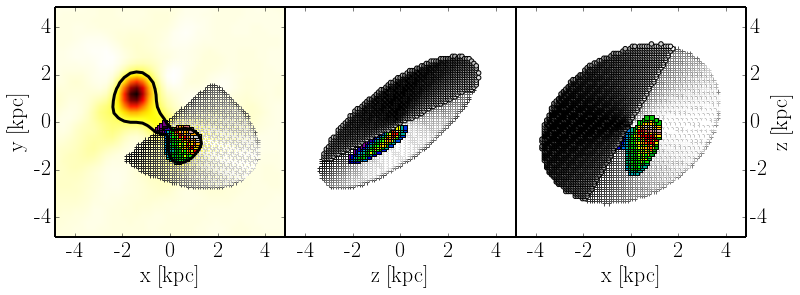

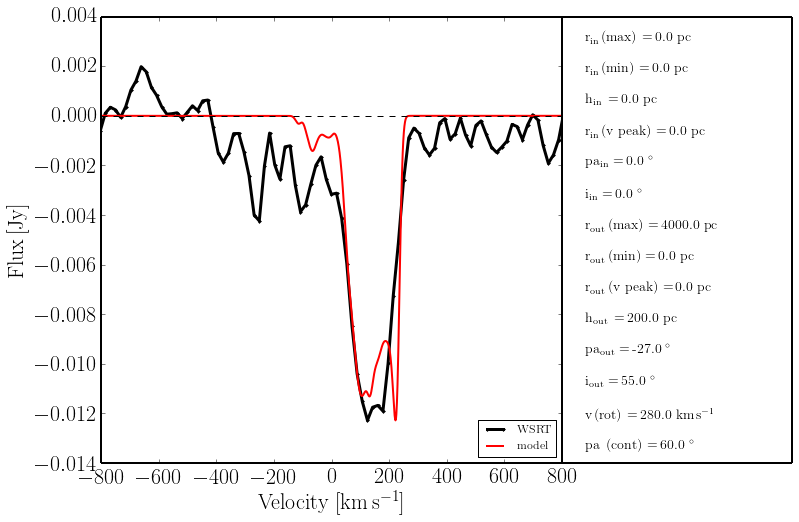

In [88]:
RES_PLT=RES*5

xdim_plt=int((xstop-xstart)/RES_PLT)+1
ydim_plt=int((ystop-ystart)/RES_PLT)+1
zdim_plt=int((2*-z_start)/RES_PLT)+1
#xdim_plt=int(9000/RES_PLT)+1
#ydim_plt=int((9000)/RES_PLT)+1
#zdim_plt=int((9000)/RES_PLT)+1

log_file = open(root_out+"output_info.txt", "aw")


date=time.strftime("\n%d-%m-%Y %H:%M")

log_file.write(date)

Normal_text='''\n\nDisk 
R Max [pc] = '''+str(RMAX)+'''\nR Min [pc] '''+str(RMIN)+'''\nHeight [pc] '''+str(H_0)+'''
PA [deg] = '''+str(PA)+''' I [deg] = '''+str(I)+'''
\nR (in) max [pc] = '''+str(RMAX)+'''\nR (in) min [pc] '''+str(RMIN)+'''\nHeight (in) [pc] '''+str(H_0)+'''
PA (in) [deg]= '''+str(PA)+''' I (in) [deg] = '''+str(I)+'''
\nVrot [km/s] = '''+str(VROT)+'''\nDisp [km/s] = '''+str(DISP)+'''
R v peak [pc] = '''+str(RMAX1)+'''
PA cont [deg] = '''+str(PA_C)+'''\n'''

log_file.write(Normal_text)

#varying I
variable=I
variablet='I'
#variable=ID2
#variablet='ID2'
#varying PA
#variable=PAD2
#variable=PA

#variablet='PA'

#variablet='PAD2'
#varying PA_C
#variable=PA_C
#variablet='PA_C'

#varying RMAX
#variable=RMAX
#variablet='RMAX'


#slowly rising
#RMAX1=RMAX/2.

#varying RMAX1
#variable=RMAX1
#variablet='RMAX1'

#varying RMIN
#variable=RMIN
#variablet='RMIN'

#varying H_0
#variable=H_0
#variablet='H_0'

# I vary one parameter for 10 times
#varying angles
#for i in xrange (0,37):
    
#varying radii
#for i in xrange (0,18):
#one cycle
for i in xrange (0,1):

    
    outfile_fig=variablet+'_'+str(i)

    
    outfile=root_out+'rotation_curve'+outfile_fig+'.jpg'
    
    
    variable_text='''\n'''+str(i)+''' -  I [deg] = '''+str(variable)
    #variable_text='''\n'''+str(i)+''' -  PA [deg] = '''+str(variable)
    #variable_text='''\n'''+str(i)+''' -  PA_C [deg] = '''+str(variable)
    #variable_text='''\n'''+str(i)+''' -  R max [pc] = '''+str(variable)

    #variable_text='''\n'''+str(i)+''' -  R min [pc] = '''+str(variable)
    #variable_text='''\n'''+str(i)+''' -  H_0 [pc] = '''+str(variable)

    log_file.write(variable_text)
    
    #define the trigonometric parameters of the disk
    #varying I
    #I_rad=math.radians(variable)
    PA_rad=math.radians(PA)
    
    #varying PA
    I_rad=math.radians(I)
    #PA_rad=math.radians(variable)
 
    PA_radD2=math.radians(PAD2)
    
    #varying PA
    I_radD2=math.radians(ID2)

    #varying PA_C
    PA_C_rad=math.radians(PA_C)
    #PA_C_rad=math.radians(variable)


    trig_I=[np.sin(I_rad),np.cos(I_rad)]
    trig_PA=[np.sin(PA_rad),np.cos(PA_rad)]
    
    trig_ID2=[np.sin(I_radD2),np.cos(I_radD2)]
    trig_PAD2=[np.sin(PA_radD2),np.cos(PA_radD2)] 

    spec_norm,spec,spec1,spec2=first_scan(outfile_fig,par)
    
    #set varying parameters
    
    #variable= variable + 5
    
    variable= variable + 5
    
    #varying RMIN
    #variable=variable + 500.
    
    #varying RMAX
    #variable=variable - 500.

    #varying I
    I=variable
    #ID2=variable

    #varying PA
    #PAD2=variable
    #PA=variable
    
    #varying PA_C
    #PA_C=variable    
    
    #varying RMAX
    #RMAX=variable
    #slowly rising
    #RMAX1=RMAX/2.
    
    #varying RMAX1
    #RMAX1=variable
    
    #varying RMIN
    #RMIN=variable
    
    #varying H_0
    #H_0=variable
    
    
    
    
    log_file.write('\n')
    
log_file.close()    

print 'NORMAL TERMINATION'

# Here the program begins: 

- i cut through the cube fixing y coordinate and moving in the horizontal direction (x), then going to the next line. 
- i cut through the cube (z direction) from $-2\times R_{\rm MAX}$ to $2\times R_{\rm MAX}$
- for each line of sight I half the resolution and check if the spectra satisfy the condition
- the condition is given by the maximum absolute difference

In [ ]:
#####MAIN MAIN MAIN  ######


print 'Beginning'

#initial conditions on the output spectrum 
specint=np.zeros([2,len(vels)])
specint[0,:]=vels[:]
  
#define output cube 
xdim=int((xstop-xstart)/RES)
ydim=int((ystop-ystart)/RES)
cube=np.zeros([len(vels),ydim,xdim])  

scale_cube=lin2ang(z_red,D_L,RES*1e-6)/3600
print scale_cube
 
    
#disk... from bottom to top
y_los=ystart

y_los_coord=0
while (y_los<ystop):
    
    #disk... from left to right 
    x_los=xstart
    x_los_coord=0

    while (x_los<xstop): 
        #initial conditions on the arrays
        cond2d=1e6
        niters2d=1.
        xstep=RES
        ystep=RES
        
        #set edges of the pixel
        x_left=x_los-RES/2.
        x_right=x_los+RES/2.
        y_down=y_los-RES/2.
        y_up=y_los+RES/2.

        #extract spectrum from centre of the pixel
        
        #continuum conditions
        x_los_cont=x_los/scale_cont_pc
        y_los_cont=y_los/scale_cont_pc
        y1=cen_y+y_los_cont
        x1=cen_x+x_los_cont
        
        flux_cont=flux_read(x_los,y_los)

        spettro,nitro,ss=cut_through(x_los,y_los,flux_cont)
        
        if flux_cont<CONT_LIM or ss==0.0:
            
            x_los+=RES 
            continue
        else:
            
            #determine the flux of the spectrum extracted from the centre of pixel
            
            #check if i'm inside the disk with the spectrum from the centre of the pixel
            print '******NEW PIX****'
            print x_los,y_los
            print '*******'
            
            #set the spectrum from the central line of sight as the first reference spectrum
            spettro_wide=spettro.copy()

            while ((cond2d>CONDITION1) and (niters2d<5)):

                #start point along the x
                y_loss=y_down
                
                #set initial conditions: the centre of the pixel has one line of sight
                spettro_thin=spettro.copy()
                numero_media=1.

                i=0
                while (y_loss<y_up+.0001):
                    x_loss=x_left
                    while (x_loss<x_right+.0001):
                            
                                flux_cont=flux_read(x_loss,y_loss)
                                flux_cont=0.
                                spettro_out=np.zeros(len(vels))
                                spettro_out,nitrogen,ss=cut_through(x_loss,y_loss,flux_cont)
                                #if ss!=0.0:
                                #    pass

                                #print x_loss,y_loss, numero_media
                                #print '********'

                                spettro_thin[:]+=spettro_out[:]
                            
                            
                                numero_media+=1.
                                i+=1
                                x_loss+=xstep

                            
                    y_loss+=ystep


                
                #normalize the spectrum
                spettro_thin=np.divide(spettro_thin,float(numero_media))
                condition_under2d=0.0

                for i in xrange(0,len(vels)):
                    condition_under2d = max(condition_under2d,math.fabs(spettro_thin[i]-spettro_wide[i]))
        
                cond2d=condition_under2d*xstep
            
                print cond2d,numero_media,niters2d

                #increase resolution for next step
                niters2d+=1.
                xstep=RES/niters2d
                ystep=RES/niters2d

                #update low res spectrum
                spettro_wide=spettro_thin.copy() 
                


            
            #sum into the total spectrum
            specint[1,:]+=spettro_thin[:]
            cube[:,y_los_coord,x_los_coord]=spettro_thin[:]

            print 'new spectrum'
            print numero_media
            print '\n'

            #save the pixel spectrum
            acab=np.column_stack((vels,specint[1,:]))
            outtxt=rootspec+'spec_'+str(x_los)+'_'+str(y_los)+'.txt'
            np.savetxt(outtxt,acab)
         
 
        #move right
        
        x_los+=RES 
        x_los_coord+=1

    #move up
    y_los+=RES
    y_los_coord+=1
    
#save the total spectrum
a=np.column_stack((vels,specint[1,:]))
outtxt=rootspec+'spectot.txt'
np.savetxt(outtxt,a)

print 'end \n'

tempofin=(time.time()-tempoinit)/60.
tempoinit=tempofin
print "total time %f minutess" % (tempofin)  
  
print 'NORMAL TERMINATION'



----------
---------

Here I check if the spectrum I produced (RED) is similar to the one predicted by an analytical function (see Stewart et al. 2014, BLUE)

----------
---------

When I=90 and PA=0, the spectrum should be perfectly symmetric: I check if the peaks are the same for what I produced and for the analytical function

In [35]:
a= specint[0,99:101]
a1= specint[1,99:101]
b= specint[0,24:26]
b1= specint[1,24:26]
c1= model[24:26]
d1= model[99:101]

#check: peaks must be the same:
print 'Spectrum'
print 'right= '+str(round(a1[1],2))
print 'left= '+str(round(b1[2],2))
print 'Function'
print c1
print d1
print a,a1
print b,b1

NameError: name 'model' is not defined

In [36]:
print specint2[1,145:155]
print specint2[0,145:155]

NameError: name 'specint2' is not defined

In [37]:
print specint[0,150]

-129.5
